In [1]:
import torch
from diffusers import StableDiffusionGLIGENPipeline
from diffusers.utils import load_image
from compel import Compel
import numpy as np
import cv2
import matplotlib.pyplot as plt


#  GENERATE

pipe = StableDiffusionGLIGENPipeline.from_pretrained(
    "masterful/gligen-1-4-inpainting-text-box", 
    variant="fp16", 
    torch_dtype=torch.float16
)
pipe = pipe.to("cuda:1")
compel = Compel(tokenizer=pipe.tokenizer, text_encoder=pipe.text_encoder)

/home/work/.conda/envs/main/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]An error occurred while trying to fetch /home/work/.cache/huggingface/hub/models--masterful--gligen-1-4-inpainting-text-box/snapshots/d6d957f8d27c40889c0d570a616571a5645c8be3/unet: Error no file named diffusion_pytorch_model.fp16.safetensors found in directory /home/work/.cache/huggingface/hub/models--masterful--gligen-1-4-inpainting-text-box/snapshots/d6d957f8d27c40889c0d570a616571a5645c8be3/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...:  29%|██▊       | 2/7 [00:01<00:04,  1.19it/s]An error occurred while trying to fetch /home/work/.cache/huggingface/hub/models--masterful--gligen-1

# Guidance Scale 변화

GLIGEN - Text prompt의 제약 조건을 따르는 정도(Guidance Scale)를 3.0 ~ 10.0까지 0.5씩 바꿔가며 테스트

In [2]:
input_image = load_image("./bg-for-hp-test.jpg")

# Rustic Style 고정정
prompt_style = "Rustic farmhouse furniture design, distressed wood, vintage charm, and cozy aesthetics, best-quality, high-quality, high-detail, 8k resolution. "
boxes = [[0.15, 0.65, 0.35, 0.9], [0.20, 0.50, 0.30, 0.70], [0.3, 0.45, 0.75, 0.9]]
phrases = ["a dresser", "a lamp", "a bed"]

# 가구 잘 생성하기 위한 문장형 프롬프트 추가
prompt_default =  "The table and table lamp and chair fits naturally in the scene, matching the lighting, perspective, and style of the background. "
prompt_default += "Ensure the table and table lamp and chair is realistic and aligns properly within the bounding box."
prompt = prompt_style + prompt_default

/home/work/.conda/envs/main/lib/python3.12/site-packages/diffusers/pipelines/stable_diffusion_gligen/pipeline_stable_diffusion_gligen.py:747: FutureWarning: Accessing config attribute `sample_size` directly via 'AutoencoderKL' object attribute is deprecated. Please access 'sample_size' over 'AutoencoderKL's config object instead, e.g. 'unet.config.sample_size'.
  if gligen_inpaint_image.size != (self.vae.sample_size, self.vae.sample_size):
/home/work/.conda/envs/main/lib/python3.12/site-packages/diffusers/pipelines/stable_diffusion_gligen/pipeline_stable_diffusion_gligen.py:748: FutureWarning: Accessing config attribute `sample_size` directly via 'AutoencoderKL' object attribute is deprecated. Please access 'sample_size' over 'AutoencoderKL's config object instead, e.g. 'unet.config.sample_size'.
  gligen_inpaint_image = self.target_size_center_crop(gligen_inpaint_image, self.vae.sample_size)
100%|██████████| 50/50 [00:09<00:00,  5.04it/s]


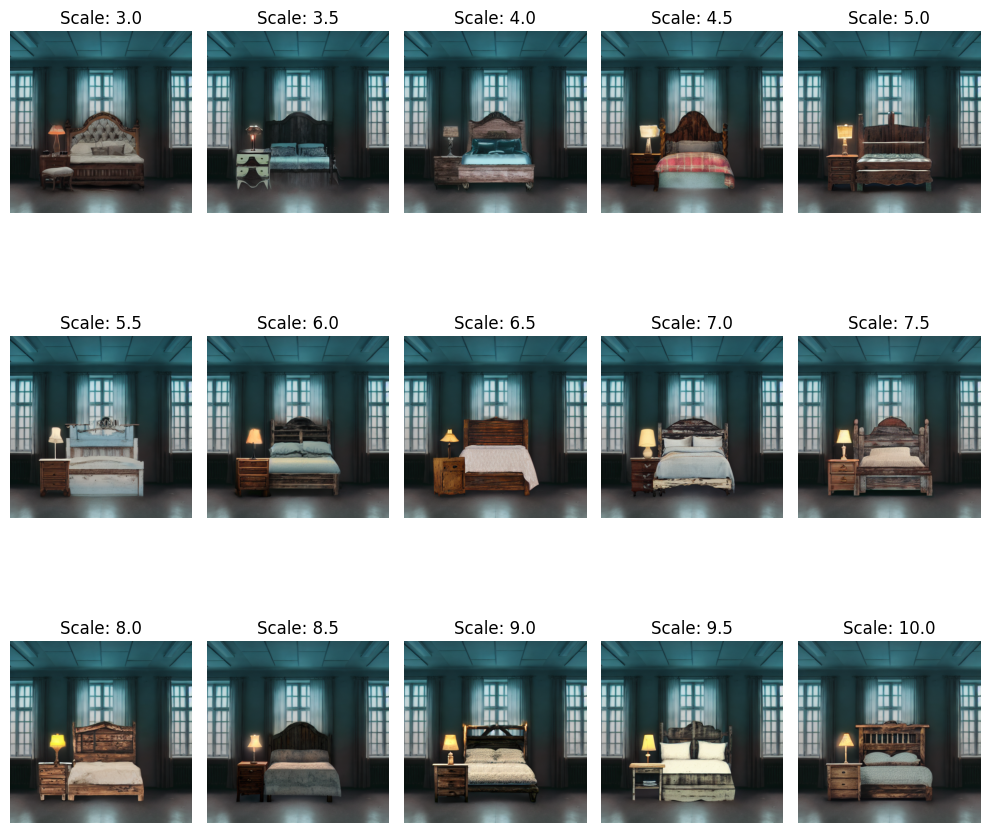

In [3]:
generator = torch.Generator(device='cuda:1').manual_seed(777)

plt.figure(figsize=(10, 10))
for idx, scale in enumerate(np.arange(3.0, 10.5, 0.5)):
    plt.subplot(3, 5, idx+1)
    images = pipe(
        prompt_embeds=compel.build_conditioning_tensor(prompt),
        gligen_phrases=phrases,
        gligen_inpaint_image=input_image,
        gligen_boxes=boxes,
        gligen_scheduled_sampling_beta=1.0,
        guidance_scale=scale,
        output_type="pil",
        num_inference_steps=50,
        generator=generator
    ).images

    np_genai = np.array(images[0])
    plt.imshow(np_genai)
    plt.title(f"Scale: {scale}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Beta 값 변화

GLIGEN - Bounding box, Class 정보에 따른른 제약 조건을 따르는 정도 (Beta) 를 0.1 ~ 1.0까지 0.1씩 바꿔가며 테스트

100%|██████████| 50/50 [00:09<00:00,  5.00it/s]


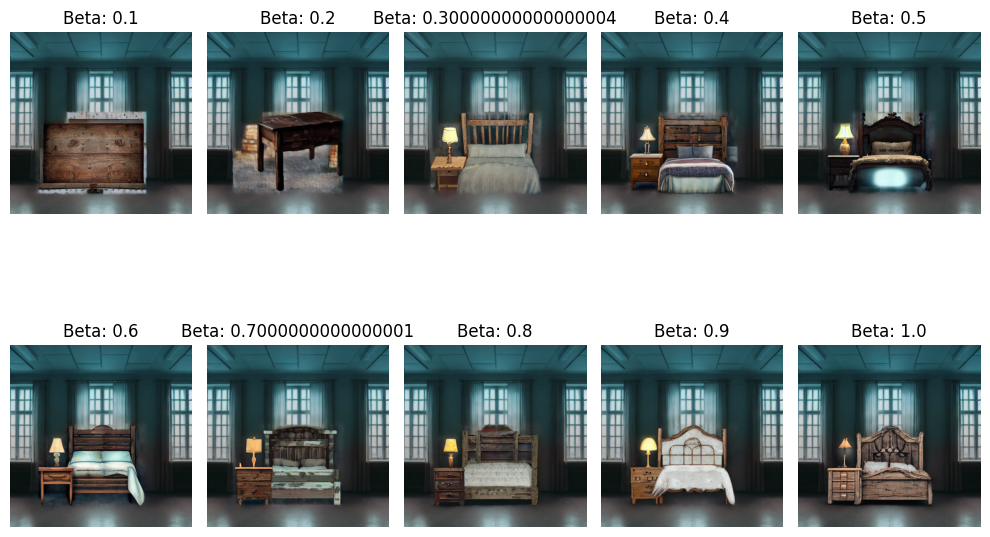

In [4]:
generator = torch.Generator(device='cuda:1').manual_seed(777)

plt.figure(figsize=(10, 10))
for idx, beta in enumerate(np.arange(0.1, 1.1, 0.1)):
    plt.subplot(3, 5, idx+1)
    images = pipe(
        prompt_embeds=compel.build_conditioning_tensor(prompt),
        gligen_phrases=phrases,
        gligen_inpaint_image=input_image,
        gligen_boxes=boxes,
        gligen_scheduled_sampling_beta=beta,
        guidance_scale=7.5,
        output_type="pil",
        num_inference_steps=50,
        generator=generator
    ).images

    np_genai = np.array(images[0])
    plt.imshow(np_genai)
    plt.title(f"Beta: {beta}")
    plt.axis('off')
plt.tight_layout()
plt.show()

- 0.0 에 가까울수록, bounding box, class의 제약 조건에 구애받지 않으므로 이미지가 자유분방하게 생성됨
- 1.0 에 가까울수록, 사용자가 원하는 객체 이미지가 원하는 위치에 정확하게 생성됨을 알 수 있음